### Workplace gradients
Use LEHD Workplace Area Characteristics to calculate the spatial distribution of jobs across US metropolitan areas

In [1]:
# import pandas for easy data manipulation
import pandas as pd

/home/clayton/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
# read in CBSA-county data
# source: http://www.census.gov/population/metro/data/def.html 
# ("Core based statistical areas (CBSAs) and combined statistical areas (CSAs)")
CBSA_counties = pd.read_excel('List1.xls', header=2)
CBSA_counties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 12 columns):
CBSA Code                                     1884 non-null object
Metro Division Code                           113 non-null float64
CSA Code                                      1214 non-null float64
CBSA Title                                    1882 non-null object
Metropolitan/Micropolitan Statistical Area    1882 non-null object
Metropolitan Division Title                   113 non-null object
CSA Title                                     1214 non-null object
County/County Equivalent                      1882 non-null object
State Name                                    1882 non-null object
FIPS State Code                               1882 non-null float64
FIPS County Code                              1882 non-null float64
Central/Outlying County                       1882 non-null object
dtypes: float64(4), object(8)
memory usage: 176.8+ KB


In [3]:
# remove couple worthless rows at the end of the dataset (source info etc)
CBSA_counties = CBSA_counties[~CBSA_counties['FIPS State Code'].isnull()]

In [ ]:
CBSA_counties.info()

In [4]:
# grab just the CBSA data we want
CBSA_counties = CBSA_counties.loc[:,('CBSA Code', 'CBSA Title', 'Metropolitan/Micropolitan Statistical Area',
                                    'FIPS State Code', 'FIPS County Code')]
# and rename columns
cols = dict(zip(['CBSA Code', 'CBSA Title', 'Metropolitan/Micropolitan Statistical Area',
                 'FIPS State Code', 'FIPS County Code'],
                ['CBSA_code', 'CBSA_title', 'Type', 'ST_FIPS', 'Cnty_FIPS']))
CBSA_counties.rename(columns=cols, inplace=True)
CBSA_counties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1882 entries, 0 to 1881
Data columns (total 5 columns):
CBSA_code     1882 non-null object
CBSA_title    1882 non-null object
Type          1882 non-null object
ST_FIPS       1882 non-null float64
Cnty_FIPS     1882 non-null float64
dtypes: float64(2), object(3)
memory usage: 88.2+ KB


In [5]:
# set up field to use to identify LEHD download url, print out to check
CBSA_counties['ST_abbrev'] = CBSA_counties['CBSA_title'].apply(lambda x: x[-2:].lower())
#print CBSA_counties['ST_abbrev'].unique()

In [6]:
# set up full county FIPS code (2-digit state plus 3-digit county, so 5 digit string total)
CBSA_counties['ST_FIPS'] = CBSA_counties['ST_FIPS'].astype(int)
CBSA_counties['Cnty_FIPS'] = CBSA_counties['Cnty_FIPS'].astype(int)
CBSA_counties['fips_cnty'] = CBSA_counties.apply(lambda x: ('0'+str(x.ST_FIPS))[-2:]+('00'+str(x.Cnty_FIPS))[-3:],
                                                axis=1)
CBSA_counties.head()

,CBSA_code,CBSA_title,Type,ST_FIPS,Cnty_FIPS,ST_abbrev,fips_cnty
0,10100,"Aberdeen, SD",Micropolitan Statistical Area,46,13,sd,46013
1,10100,"Aberdeen, SD",Micropolitan Statistical Area,46,45,sd,46045
2,10140,"Aberdeen, WA",Micropolitan Statistical Area,53,27,wa,53027
3,10180,"Abilene, TX",Metropolitan Statistical Area,48,59,tx,48059
4,10180,"Abilene, TX",Metropolitan Statistical Area,48,253,tx,48253


In [ ]:
# download and extract desired LEHD data

# static URL info
base = 'http://lehd.ces.census.gov/data/lodes/LODES7/'
end = '_wac_S000_JT00_2013.csv.gz' # 2014 data exists for all states except WY as of March 31, 2016

# add extracted data to this list
DFs = []
# iterate through CBSA codes
for s in CBSA_counties.ST_abbrev.unique():
    try:
        # try to get data
        df = pd.read_csv(base+'{0:}/wac/{0:}'.format(s)+end, compression='gzip')
        # grab only desired columns of downloaded data
        df = df.loc[:,('w_geocode', 'C000')]
        # correct pandas annoying habit of setting numbers to numeric type
        df['w_geocode'] = df['w_geocode'].astype(str)
        df['w_geocode'] = df['w_geocode'].apply(lambda x: ('00'+x)[-15:])
        df['cnty_fips'] = df['w_geocode'].apply(lambda x: x[:5])
        # subset df to just counties we want for this state
        df = df[df.cnty_fips.isin(CBSA_counties[CBSA_counties.ST_abbrev==s].fips_cnty.values.tolist())]
        # add this df to list of DFs
        DFs.append(df)
    except:
        print 'failed for state {}'.format(s)
        
# combine all downloaded data into single dataframe
df = pd.concat(DFs)

PR does not download -> *which is fine, as PR does not have any LODES data so failing for it is expected*

In [ ]:
df.info()

In [ ]:
# save out WAC interim file
df.to_csv('interim_data/cbsa_wac_2013.csv', index=False, index_label=False)

In [8]:
# if already extracted LODES
df = pd.read_csv('interim_data/cbsa_wac_2013.csv', dtype={'w_geocode': str, 'cnty_fips': str})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1466364 entries, 0 to 1466363
Data columns (total 3 columns):
w_geocode    1466364 non-null object
C000         1466364 non-null int64
cnty_fips    1466364 non-null object
dtypes: int64(1), object(2)
memory usage: 33.6+ MB


In [16]:
# and get appropriate block location data
import geopandas as gpd
#from StringIO import StringIO
from io import BytesIO
from zipfile import ZipFile
import requests

In [ ]:
# iteratively downloads each shapefile for all 1,882 counties to "spatial_data" in working directory
# "shapefile" actually consists of ~5 files, so total downloaded and extracted around ~9.4k files
shpList = []
for c in df.cnty_fips.unique():
    try:
        # set url info for download
        tbl = 'tl_2010_{}_tabblock10.zip'.format(c)
        url = 'http://www2.census.gov/geo/tiger/TIGER2010/TABBLOCK/2010/'+tbl
        # set download info and zipfile info for extracting the data
        r = requests.get(url)
        f = ZipFile(BytesIO(r.content))
        # extract shapefile to spatial_data folder
        f.extractall('spatial_data/')
        # add downloaded file to list to read in later
        shpList.append('spatial_data/'+tbl[:-3]+'shp')
    except:
        print 'failed for county {}'.format(c)

In [13]:
# if shapefiles already downloaded, re-create shpList with counties from LODES data
shpList = ['spatial_data/tl_2010_'+c+'_tabblock10.shp' for c in df.cnty_fips.unique()]

In [40]:
# read in all the downloaded shapefiles and compile to single GeoDataFrame
# takes a while to run through (reading in >1800 shapefiles, getting center point, subsetting, and concatenating)
blocks = pd.DataFrame()
for f in shpList:
    # read in shapefile 'f'
    b = gpd.read_file(f)
    # create center point lat/lon
    b['lon'] = b.geometry.apply(lambda r: r.centroid.x)
    b['lat'] = b.geometry.apply(lambda r: r.centroid.y)
    # subset to just desired data and set as DataFrame object
    b = pd.DataFrame(b.loc[:, ('GEOID10', 'UR10', 'lon', 'lat')])
    # concatenate each to "blocks"
    blocks = pd.concat([blocks, b], ignore_index=True)
    
blocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7106456 entries, 0 to 7106455
Data columns (total 4 columns):
GEOID10    object
UR10       object
lon        float64
lat        float64
dtypes: float64(2), object(2)
memory usage: 271.1+ MB


In [49]:
# add county FIPS
blocks['cnty_fips'] = blocks.GEOID10.apply(lambda x: x[:5])

In [59]:
# create for faster county -> cbsa lookup
cbsa_lookup = dict(CBSA_counties.loc[:,('fips_cnty', 'CBSA_code')].values)

In [62]:
# and add CBSA code
blocks['CBSA_code'] = blocks.cnty_fips.apply(lambda x: cbsa_lookup[x])
blocks.head()

,GEOID10,UR10,lon,lat,cnty_fips,CBSA_code
0,460059566001068,R,-98.103794,44.333773,46005,26700
1,460059566001066,R,-98.103950,44.319286,46005,26700
2,460059566002600,R,-98.100149,44.370025,46005,26700
3,460059568001219,R,-98.176908,44.365373,46005,26700
4,460059571001032,R,-98.186713,44.357983,46005,26700


In [63]:
# create CBSA centroids based on average block location
# this is not the same as taking the center point of the bounding box for the CBSA
# because blocks have variable sizes based on population distribution
# but, in general it will be fairly close to the geographic center point of the CBSA
cbsa = blocks.groupby('CBSA_code')['lat', 'lon'].mean()
cbsa.reset_index(inplace=True)
cbsa.head()

,CBSA_code,lat,lon
0,10100,45.510600,-98.580639
1,10140,47.047869,-123.770211
2,10180,32.477364,-99.744752
3,10220,34.758250,-96.666263
4,10300,41.919051,-84.058945


In [113]:
# Haversine formula good enough proxy for distances
# https://gist.github.com/rochacbruno/2883505
# Author: Wayne Dyck

#import math
from math import radians, atan2, sin, cos, sqrt, degrees

def distance(origin, destination, u='km'):
    lat1, lon1 = origin
    lat2, lon2 = destination
    if u=='km':
        radius = 6371 # km
    elif u=='mi':
        radius = 3956 # miles
    else:
        raise # need to define units for radius

    dlat = radians(lat2-lat1)
    dlon = radians(lon2-lon1)
    a = sin(dlat/2.) * sin(dlat/2.) + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2.) * sin(dlon/2.)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = radius * c

    return d

## and bearing from 
#http://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
# due south = 0, scale 0-360 clockwise
def bearing(lat1, lon1, lat2, lon2):
    b = atan2(sin(lon2-lon1)*cos(lat2), 
              cos(lat1)*sin(lat2)-sin(lat1)*cos(lat2)*cos(lon2-lon1))
    b = degrees(b)
    b = (b + 360) % 360
    return b

In [66]:
# add desired geographic info to df (LODES jobs' locations)
df = df.merge(blocks.loc[:,('GEOID10', 'UR10', 'lon', 'lat', 'CBSA_code')], left_on='w_geocode', right_on='GEOID10')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1466364 entries, 0 to 1466363
Data columns (total 8 columns):
w_geocode    1466364 non-null object
C000         1466364 non-null int64
cnty_fips    1466364 non-null object
GEOID10      1466364 non-null object
UR10         1466364 non-null object
lon          1466364 non-null float64
lat          1466364 non-null float64
CBSA_code    1466364 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 100.7+ MB


In [72]:
# and another dictionary for faster CBSA lat/lon lookup
cbsa_points = dict(zip(cbsa.CBSA_code.values, cbsa.loc[:, ('lat', 'lon')].values))

In [97]:
# calculate distance from block to CBSA center point
df['distKm'] = df.apply(lambda r: distance((r.lat, r.lon),
                                           (cbsa_points[r.CBSA_code][0],cbsa_points[r.CBSA_code][1])),
                        axis=1)

In [90]:
# and bearing to city center
df['bearing'] = df.apply(lambda r: bearing(r.lat, r.lon, cbsa_points[r.CBSA_code][0],cbsa_points[r.CBSA_code][1]),
                                     axis=1)
df.head()

,w_geocode,C000,cnty_fips,GEOID10,UR10,lon,lat,CBSA_code,distKm,bearing
0,460059566001035,14,46005,460059566001035,R,-97.873987,44.361081,26700,31.094400,281.936284
1,460059566001040,3,46005,460059566001040,R,-97.856266,44.365618,26700,32.403127,281.154110
2,460059566001071,91,46005,460059566001071,R,-98.142303,44.347356,26700,11.552066,300.845198
3,460059566001197,3,46005,460059566001197,R,-98.223158,44.275436,26700,15.105102,346.025974
4,460059566001251,8,46005,460059566001251,R,-98.224083,44.247419,26700,18.161122,348.648071


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1466364 entries, 0 to 1466363
Data columns (total 10 columns):
w_geocode    1466364 non-null object
C000         1466364 non-null int64
cnty_fips    1466364 non-null object
GEOID10      1466364 non-null object
UR10         1466364 non-null object
lon          1466364 non-null float64
lat          1466364 non-null float64
CBSA_code    1466364 non-null object
distKm       1466364 non-null float64
bearing      1466364 non-null float64
dtypes: float64(4), int64(1), object(5)
memory usage: 123.1+ MB


In [81]:
%matplotlib inline
import matplotlib.pyplot as plt

In [98]:
# save out interim df with distances and bearings to city centers
df.to_csv('interim_data/metro_wac_wDistBearings.csv', index=False, index_label=False)

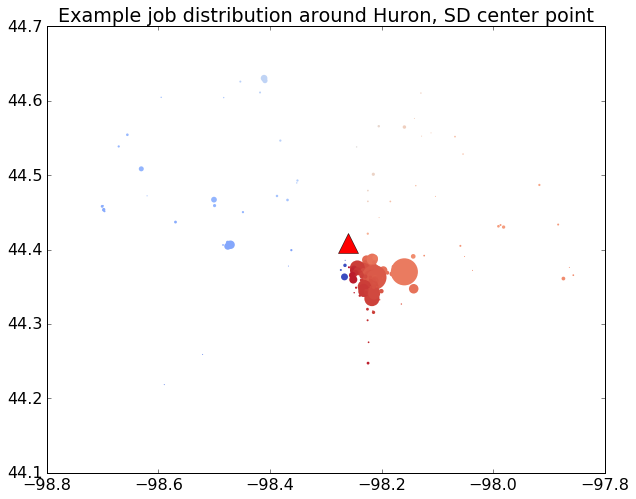

In [114]:
plt.rcParams.update({'font.size': 16})
f, ax = plt.subplots(figsize=(10,8))

# blocks sized by jobs and colored by bearing
ax.scatter(df[df.CBSA_code=='26700'].lon, df[df.CBSA_code=='26700'].lat, edgecolor='none',
           s=df[df.CBSA_code=='26700'].C000,
           c=df[df.CBSA_code=='26700'].bearing, cmap=plt.cm.get_cmap('coolwarm'))

# plot city center as red triangle
ax.plot(cbsa_points['26700'][1], cbsa_points['26700'][0], '^r', markersize=20)

ax.set_title('Example job distribution around {} center point'.format(
    CBSA_counties[CBSA_counties.CBSA_code=='26700'].loc[:,'CBSA_title'].values[0]))


In [117]:
cbsa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 3 columns):
CBSA_code    917 non-null object
lat          917 non-null float64
lon          917 non-null float64
dtypes: float64(2), object(1)
memory usage: 21.6+ KB


In [121]:
print len(cbsa_lookup.keys())
#print sorted(cbsa_lookup.keys())

1882


In [122]:
CBSA_counties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1882 entries, 0 to 1881
Data columns (total 7 columns):
CBSA_code     1882 non-null object
CBSA_title    1882 non-null object
Type          1882 non-null object
ST_FIPS       1882 non-null int64
Cnty_FIPS     1882 non-null int64
ST_abbrev     1882 non-null object
fips_cnty     1882 non-null object
dtypes: int64(2), object(5)
memory usage: 117.6+ KB


In [129]:
# add name, type, and count of counties for each CBSA
cbsa = cbsa.merge(CBSA_counties.groupby(['CBSA_code', 'CBSA_title', 'Type'])['Cnty_FIPS'].count().reset_index(),
                 left_on='CBSA_code', right_on='CBSA_code')
# rename count field
cbsa.rename(columns={'Cnty_FIPS': 'num_counties'}, inplace=True)
cbsa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 917 entries, 0 to 916
Data columns (total 6 columns):
CBSA_code       917 non-null object
lat             917 non-null float64
lon             917 non-null float64
CBSA_title      917 non-null object
Type            917 non-null object
num_counties    917 non-null int64
dtypes: float64(2), int64(1), object(3)
memory usage: 50.1+ KB


In [136]:
# example to subset by city name
cbsa[cbsa.CBSA_title.isin([test for test in cbsa.CBSA_title.values if 'New York' in test])]

,CBSA_code,lat,lon,CBSA_title,Type,num_counties
596,35620,41.328218,-75.011844,"New York-Newark-Jersey City, NY-NJ-PA",Metropolitan Statistical Area,25


In [138]:
cbsa.to_csv('interim_data/CBSAs.csv', index=False, index_label=False, encoding='UTF-8')